# Project 4 - Movie Recommendation App
# STAT 542 Statistical Learning - Fall 2022

In this project, we build a Movie Recommendation App based on a dataset of movie ratings from IMDB website.

In this notebook, we validate two strategies used for the recomender engine:

1. Having the user choose a movie genre and recommend the movies with highest number of reviews or average ratings for that genre.
2. Having the user rate a couple of movies and then use Item Based Collaborative Filtering (IBCF) method to recommend other movies that match his preferences.

Once these two approaches are validated, we deploy the recommender using R and the ShinyApps platform. The code used for that (including the UI and recommender) can be found at https://github.com/paoloff/UIUC_DSE/tree/main/STAT542-Statistical-Learning/Projects/Project%204%20-%20Movie%20Recommendation%20App/MovieRec.

The app can be found at:
https://paoloff.shinyapps.io/movierec/

Here's a picture of how it looks like!

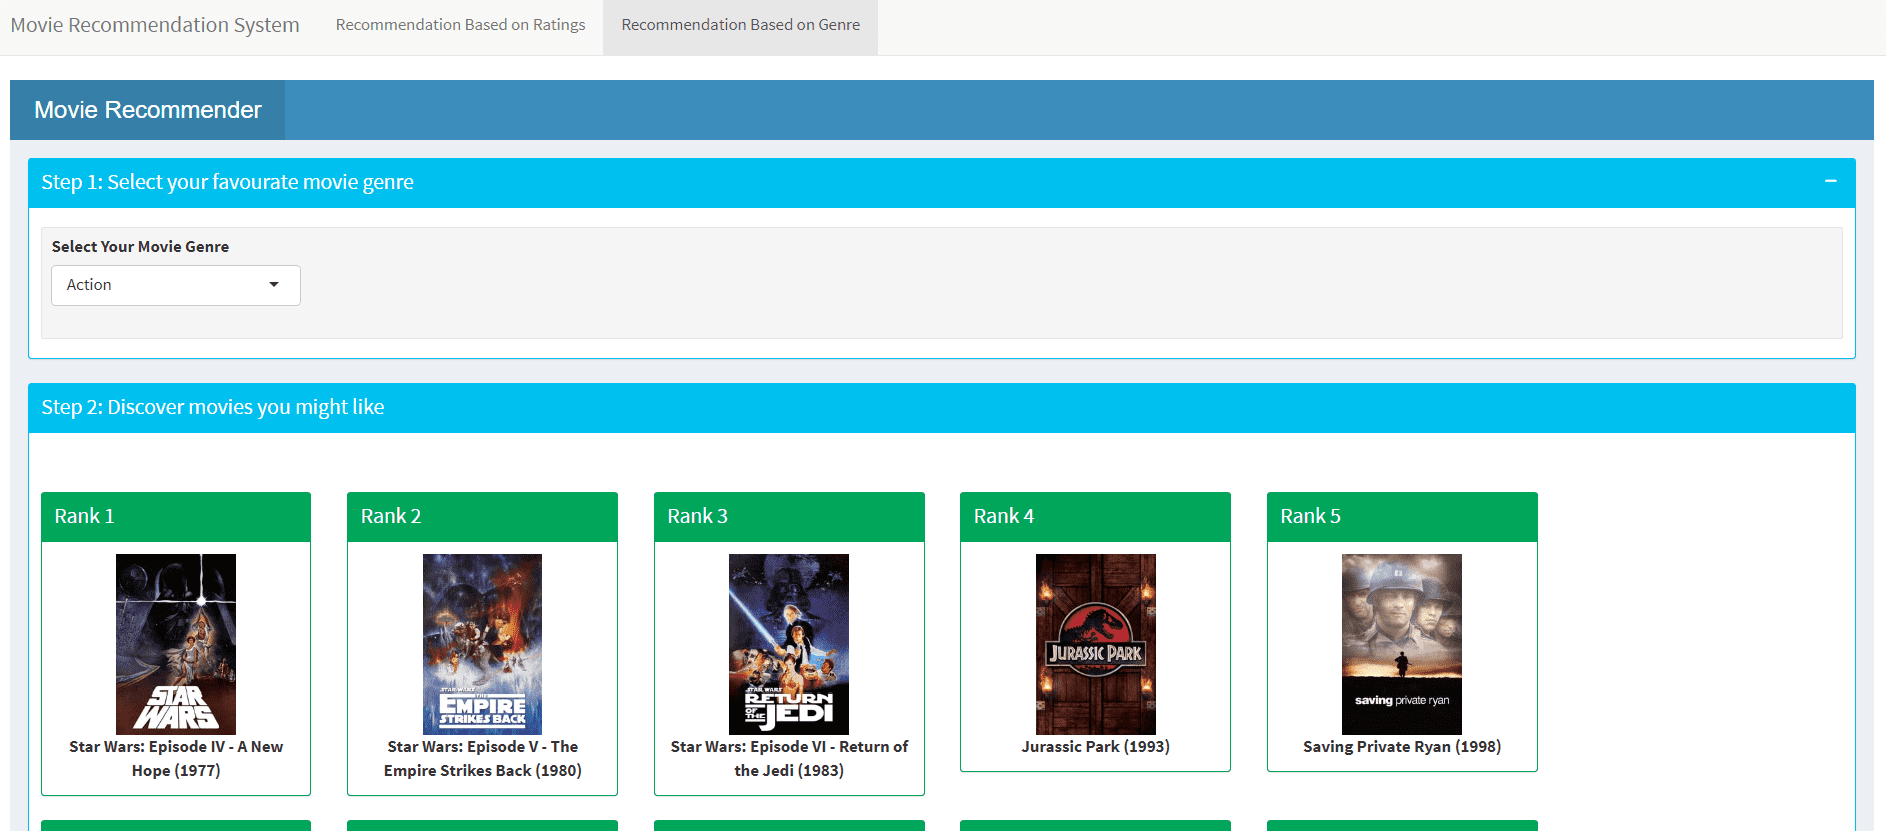

In [1]:
from IPython.display import Image
Image(filename='mrec.png') 

----

# I. Data preparation

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

### Read data:

In [3]:
ratings = pd.read_table("https://liangfgithub.github.io/MovieData/ratings.dat",sep="::",header=None,engine='python')
ratings.columns = ['UserID','MovieID','Rating','Timestamp']
ratings['UserID'] = ratings['UserID'].apply(lambda x:'u' + str(x))
ratings['MovieID'] = ratings['MovieID'].apply(lambda x:'m' + str(x))

In [4]:
ratings.head(3)

,UserID,MovieID,Rating,Timestamp
0,u1,m1193,5,978300760
1,u1,m661,3,978302109
2,u1,m914,3,978301968


In [5]:
movies = pd.read_table("https://liangfgithub.github.io/MovieData/movies.dat",sep="::",header=None,engine='python',encoding='latin-1')
movies.columns = ['MovieID','Title','Genres']
movies['MovieID'] = movies['MovieID'].apply(lambda x:'m' + str(x))
movies.head(3)

,MovieID,Title,Genres
0,m1,Toy Story (1995),Animation|Children's|Comedy
1,m2,Jumanji (1995),Adventure|Children's|Fantasy
2,m3,Grumpier Old Men (1995),Comedy|Romance


---
# II. Recommendation based on genres

For doing recommendation based on genres, we first calculate the average rating of each movie, the number of ratings received by each movie, and the genres of each movie.


In [6]:
users = pd.read_table("https://liangfgithub.github.io/MovieData/users.dat",sep="::",header=None,engine='python',encoding='latin-1')
users.columns = ['UserID','Gender', 'Age', 'Occupation', 'Zip-code']
users['UserID'] = users['UserID'].apply(lambda x:'m' + str(x))

users.head(3)

,UserID,Gender,Age,Occupation,Zip-code
0,m1,F,1,10,48067
1,m2,M,56,16,70072
2,m3,M,25,15,55117


In [7]:
genre_dic = defaultdict(list)
for i in range(len(movies)):
    info = movies.iloc[i]
    mid = info['MovieID']
    title = info['Title']
    genres = info['Genres'].split('|')
    for genre in genres:
        genre_dic[genre].append(mid)

In [8]:
id_title_mapping = {}
for i in range(len(movies)):
    id_title_mapping[movies['MovieID'].iloc[i]] = movies['Title'].iloc[i]

In [9]:
movie_avr_score = defaultdict(float)
movie_rated_frq = defaultdict(int)

In [10]:
rating_by_movie = ratings[['MovieID','Rating','Timestamp']].groupby(['MovieID'], group_keys=False).mean()
rating_by_movie.head(3)

,Rating,Timestamp
MovieID,,
m1,4.146846,9.705586e+08
m10,3.540541,9.720168e+08
m100,3.062500,9.717403e+08


In [11]:
for idx in rating_by_movie.index:
    movie_avr_score[idx] = rating_by_movie['Rating'].loc[idx]

### Method 1: Most Popular Recommendation

The first genre-based recommendation method we propose is "most popular recommendation". Specifically, we define "populartity" by the number of ratings a movie receives. The more ratings a movie receives, the more popular it is.

To recommend the "top 5 most popular movie" for each genre, we first find all movies belonging to this genre. Then, we sort the movies by the number of ratings they receive, and return the top 5 movies as our recommendation results.

In [12]:
freq_by_movie = ratings.groupby('MovieID', group_keys=False).count()
freq_by_movie.head(3)

,UserID,Rating,Timestamp
MovieID,,,
m1,2077,2077,2077
m10,888,888,888
m100,128,128,128


In [13]:
for idx in freq_by_movie.index:
    movie_rated_frq[idx] = freq_by_movie['Rating'].loc[idx]


Let's take a look at the movies with the most reviews for the first 5 genres:

In [14]:
def Popular_Recom(fav):
    if (fav not in genre_dic.keys()):
        return ''
    similar_movies = genre_dic[fav]
    similar_movies.sort(key=lambda x: movie_rated_frq[x], reverse=True)
    return similar_movies[:5]

for genre in list(genre_dic.keys())[:5]:
    mids = Popular_Recom(genre)
    titles = [id_title_mapping[i] for i in mids]
    print('\n', genre + ': {}'.format(titles))



 Animation: ['Toy Story (1995)', 'Who Framed Roger Rabbit? (1988)', "Bug's Life, A (1998)", 'Toy Story 2 (1999)', 'Aladdin (1992)']

 Children's: ['E.T. the Extra-Terrestrial (1982)', 'Toy Story (1995)', 'Babe (1995)', 'Wizard of Oz, The (1939)', "Bug's Life, A (1998)"]

 Comedy: ['American Beauty (1999)', 'Back to the Future (1985)', 'Men in Black (1997)', 'Shakespeare in Love (1998)', 'Princess Bride, The (1987)']

 Adventure: ['Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Jurassic Park (1993)', 'Men in Black (1997)']

 Fantasy: ['Star Wars: Episode IV - A New Hope (1977)', 'E.T. the Extra-Terrestrial (1982)', 'Star Wars: Episode I - The Phantom Menace (1999)', 'Beetlejuice (1988)', 'Big (1988)']


### Method 2: Highest Average Recommendation

The second genre-based recommendation method we propose is "highest average recommendation". To recommend the "top 5 highest rated movie" for each genre, we first find all movies belonging to this genre. Then, we sort the movies by the average rating they receive, and return the top 5 movies as our recommendation results.



In [15]:
def Rating_Recom(fav):
    if (fav not in genre_dic.keys()):
        return ''
    similar_movies = genre_dic[fav]
    similar_movies.sort(key=lambda x: movie_avr_score[x], reverse=True)
    return similar_movies[:5]

for genre in list(genre_dic.keys())[:5]:
    mids = Rating_Recom(genre)
    titles = [id_title_mapping[i] for i in mids]
    print(genre + ': {}'.format(titles))
    print()

Animation: ['Close Shave, A (1995)', 'Wrong Trousers, The (1993)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Grand Day Out, A (1992)', 'Creature Comforts (1990)']

Children's: ['Wizard of Oz, The (1939)', 'Toy Story 2 (1999)', 'Toy Story (1995)', 'Iron Giant, The (1999)', 'Winnie the Pooh and the Blustery Day (1968)']

Comedy: ['Smashing Time (1967)', 'Follow the Bitch (1998)', 'One Little Indian (1973)', 'Close Shave, A (1995)', 'Wrong Trousers, The (1993)']

Adventure: ['Ulysses (Ulisse) (1954)', 'Sanjuro (1962)', 'Raiders of the Lost Ark (1981)', 'Star Wars: Episode IV - A New Hope (1977)', 'Lawrence of Arabia (1962)']

Fantasy: ['Star Wars: Episode IV - A New Hope (1977)', 'Hungarian Fairy Tale, A (1987)', 'E.T. the Extra-Terrestrial (1982)', 'Heavenly Creatures (1994)', 'Willy Wonka and the Chocolate Factory (1971)']



# 3. Recommendation based on IBCF method

### How does IBCF work?

Suppose we have 4 movies and 3 users in our database. We can then create a **user-item** matrix where each entry at position (i,j) is the score given by user i to movie j. In our example, user-item matrix the should look like

||Movie 1| Movie 2| Movie 3| Movie 4|
|-|-|-|-|-|
|User 1| 3||4|4|
|User 2|1|1|3|3|
|User 3|2|||5|

**The goal of the IBCF (Item Based Collaborative Filtering) method is to infer the rating of a movie by an user given the similarity that that movie has with the other movies rated by the user.**

For our example, ICBF proposes that the rating (i,j) of a movie j by an user i should follow a weighted average of all other ratings done by the user as follows:

$$
PredictedRating(i,j) =  \frac{\sum_{j'=1}^4 Rating(i,j')*Similarity(j',j)}{\sum_{j'=1}^4 Similarity(j',j)}
$$

In this formula, the similarity function is usually chosen to be the **Cosine Similarity** between any two-vectors. Note that **when applying the IBFC and Cosine Similarity formulae, any missing rating assumes a value of 0.**

Thus, if a missing rating is found in the dataset, such as the rating of Movie 2 by User 1 in out table, we can use the formula above to try to estimate it.
**This way, by having a new user rate a couple of movies in our app, we can recommend other movies by calculating the IBCF predicted ratings and recommending only the movies with highest scores!**

In the next sessions, we will implement all the code necessary to compute the ICBF ratings from our dataset of reviews.

### User-Item Matrix

Here, we create a index-username map to map each username to a row in the user-item rating matrix


In [16]:
users_ids = sorted(list(set(ratings['UserID'].values)))


In [17]:
user_index_map = {}
index_user_map = {}
for i in range(len(users_ids)):
    user_index_map[users_ids[i]] = i
    index_user_map[i] = users_ids[i]

In [18]:
movies_ids = sorted(list(set(ratings['MovieID'].values)))


In [19]:
movie_index_map = {}
index_movie_map = {}
for i in range(len(movies_ids)):
    movie_index_map[movies_ids[i]] = i
    index_movie_map[i] = movies_ids[i]

Create the user-item grading matrix. Row: User; Col: Item


In [20]:
ui_grading_matrix = np.zeros([len(users_ids), len(movies_ids)])

for i in range(ui_grading_matrix.shape[0]):
    uid = index_user_map[i]
    user_ratings = ratings.loc[ratings['UserID'] == uid]
    for j in range(len(user_ratings)):
        msg = user_ratings.iloc[j]
        mid = msg['MovieID']
        ui_grading_matrix[i, movie_index_map[mid]] = msg['Rating']

In [21]:
iu_grading_matrix = ui_grading_matrix.copy()

Calculate the average rating for each user and normalize each row


In [22]:
user_avr = {}
for i in range(ui_grading_matrix.shape[0]):
    count = 0
    summation = 0
    for rating in ui_grading_matrix[i]:
        if (rating != 0):
            summation += rating
            count += 1
    user_avr[i] = summation / count
    

In [23]:
for i in range(ui_grading_matrix.shape[0]):
    for j in range(ui_grading_matrix.shape[1]):
        if (ui_grading_matrix[i, j] != 0):
            ui_grading_matrix[i, j] -= user_avr[i]

### Cosine similarity function

In [24]:
def cosine_sim(x, y):    
    x_adj = []
    y_adj = []
    for i in range(len(x)):
        if (x[i] != 0 and y[i] != 0):
            x_adj.append(x[i])
            y_adj.append(y[i])
    x = np.asarray(x_adj)
    y = np.asarray(y_adj)
    if (len(x) == 0 or len(y) == 0):
        return -float('inf'), -float('inf')
    
    return (1 + np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))) / 2, len(x)

In [25]:
def get_similarities(training_users, test_vector, threshold):
    similarity_heap = []
    for i in range(training_users.shape[0]):
        similarity, common = cosine_sim(training_users[i], test_vector)
        similarity_heap.append((similarity, i))
    similarity_heap.sort(key=lambda x: x[0])
    return similarity_heap[-threshold:]

### IBCF

Finally, we implement the main function which calculates the ICBF given the cosine similarity function and the user-item matrix:

In [26]:
def get_ibcf_similarity(training, threshold):
    movie_similarity_dic = defaultdict(list)
    training = training.T
    for i in range(training.shape[0]):
        vec1 = training[i]
        similars = []
        for j in range(training.shape[0]):
            if (i == j):
                continue
            vec2 = training[j]
            similarity, commons = cosine_sim(vec1, vec2)
            similars.append((similarity, commons, j))
        similars.sort(key=lambda x:(x[0]))
        movie_similarity_dic[i] = similars[-threshold:]
    return movie_similarity_dic

In [27]:
def IBCF_rating(movie_similarity_dic, testing_user):
    predictions = [np.NaN for _ in range(len(testing_user))]
    for j in range(len(predictions)):
        if (testing_user[j] != 0):
            continue
        total_weighted_rating = 0
        total_sim = 0
        for (similarity, commons, movie_idx) in movie_similarity_dic[j]:
            if (testing_user[movie_idx] != 0 and similarity != -float('inf')):
                total_sim += similarity
                total_weighted_rating += similarity * testing_user[movie_idx]
        if (total_weighted_rating != 0):
            predictions[j] = total_weighted_rating / total_sim
    return predictions

We use the first 500 users as the training data, and use the rest as test. 

To compute the predictions, first we calculate the cosine similarity between movies using the training users:

In [28]:
train_number = 500
training_users = ui_grading_matrix[ : train_number, :]
test_users = iu_grading_matrix[train_number, :]
ibcf_k = 30
movie_similarities = get_ibcf_similarity(training_users, ibcf_k)


Finally, we feed the similarities into the IBCF function to get the predicted ratings

In [29]:
ibcf_pred = IBCF_rating(movie_similarities, test_users)
